In [1]:
import cv2
import numpy as np
import csv
import threading
from matplotlib import pyplot as plt
from Expression_Network import Expression_Network as enet
import traceback
import phue
from phue import Bridge
import time

# Test Face detection pipeline

faces found:  1


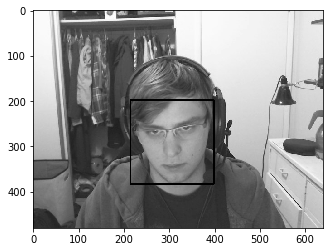

In [2]:
# initialize cascada classifier
haar_cascade = cv2.CascadeClassifier(
    'data/haarcascade_frontalface_alt.xml')

#initialize default. Change int argument to change webcam used.
cam = cv2.VideoCapture(0)

#read img from camera and make a gray version for the cascada classifier
ret_val, img = cam.read()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#use the classifier to detect faces. Returns face box coordinates for each face
faces = haar_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
print("faces found: ", len(faces))

#for each face, draw a rectangle around it
for (x, y, w, h) in faces:
         cv2.rectangle(gray, (x, y), (x+w, y+h), (0, 255, 0), 2)

# display the img
plt.imshow(gray,cmap="gray")

# Import Labels

In [3]:
intToLabel = {}
with open('data/labelList.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        intToLabel[int(row[0])] = row[1]
print(intToLabel)

{0: 'Happy', 1: 'Sad', 2: 'Angry', 3: 'Neutral'}


# Detection/Prediction Pipeline
(only works with one face on screen at a time)

In [4]:
# Data class holds all of the information that all the other functions 
# need to pass between eachother. 
class data():
    def __init__(self):
        #coordinate array of the last faces detected
        self.faces = None
        #latist image from camera
        self.latestim = None
        # whether there is a camera image
        self.gotimage = False
        # whether there is a face detected
        self.gotface = False
        # blk and white zoomed in image of face
        self.faceim = None
        # emotion prediction
        self.prediction = None
        # True if user has quit program. Tells other processes to stop
        self.done = False



#Gets face coordinates
def get_faces(data):
    try:
        print("detecting faces")
        haar_cascade = cv2.CascadeClassifier(
            'data/haarcascade_frontalface_alt.xml')
        #if we haven't quit the program and have an image to detect faces in
        while not data.done:
            if data.gotimage:
                # get face coordinates and write them to data
                newfaces = haar_cascade.detectMultiScale(data.latestim, scaleFactor=1.1, minNeighbors=5)
                data.faces = newfaces
                data.gotface = True
    except Exception as e:
        print("exception in get_faces loop")
        traceback.print_exc()
        data.done = True
        
def hue_control(data):
    try:
        #xy color values for each emotion
        colors = [[.1,.75],[.12,.1],[.64,.35],[.3,.3]]
        
        #connect to hue bridge with local ip address and get lights
        b = Bridge('192.168.1.23')
        b.connect()
        lights = b.get_light_objects()
        
        #for each light, set the transition time to the minimum to make for quick changes, and max brightness
        for light in lights:
                    light.transitiontime = 0
                    light.brightness = 255
                    
        #quit if the program is finished running
        while not data.done:
            if data.prediction is not None:
                #for each light, set the colors the corosponding prediction.
                for light in lights:
                    light.xy = colors[data.prediction]
                #setting light colors involves a call and responce and runs better if you give it time to complete
                time.sleep(.5)
                
        #if the program has ended set the lights to white
        else:
            for light in lights:
                light.brightness = 255
                light.xy = [.3,.3]
                
    #print exceptions, tell the other threads to stop, set lights to white.            
    except Exception as e:
        print("exception in hue_control loop")
        traceback.print_exc()
        data.done = True
        for light in lights:
                light.brightness = 255
                light.xy = [.3,.3]
        
        
def display(data):
    try:
        #initialize camera
        cam = cv2.VideoCapture(0)
        while not data.done:
            ret_val, img = cam.read()
            if ret_val == True:
                img = cv2.flip(img,1)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                data.latestim = gray
                data.gotimage = True
                if data.gotface:
                    for (x, y, w, h) in data.faces: 
                        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
                        faceim = gray[y:y+h,x:x+w]
                        data.faceim = cv2.resize(faceim,(128,128))
                        label = "None" 
                        if data.prediction is not None:
                            label = intToLabel[data.prediction]
                        cv2.putText(img,label,
                                    (x,y-5),cv2.FONT_HERSHEY_SIMPLEX,.5,(0,255,0))

                cv2.imshow('my webcam', img)
            else:
                data.done = True

            if cv2.waitKey(1) == 27 or data.done == True: 
                data.done= True
                print("face detection stopped")
                break  # esc to quit
        cv2.destroyAllWindows()
    except Exception as e:
        data.done = True
        cam.release()
        print("exception in display loop")
        traceback.print_exc()
        
def test_loop(data):
    starttime = time.time()
    try:
        while time.time() - starttime < 10:
            im = cv2.imread("images/face{}.png".format(np.random.randint(1,1500)),0)
            if im is not None:
                data.faceim = cv2.resize(im,(128,128))
            
    except Exception as e:
        data.done = True
        cam.release()
        print("exception in test loop")
        traceback.print_exc()
            
           


In [5]:
shared = data()
network = enet(4)

In [6]:
im = cv2.imread("images/face200.png",0)
im = cv2.resize(im,(128,128))
d = data()
d.faceim = im
network.predict([im])
#im = cv2.imread("images/face{}.png".format(np.random.randint(1,1500)),0)
#if im is not None:
#    shared.faceim = cv2.resize(im,(128,128))

AttributeError: 'Expression_Network' object has no attribute 'model'

In [7]:
threading.Thread(target=network.predict_loop,args=[shared]).start()
#threading.Thread(target=test_loop,args=[shared]).start()
threading.Thread(target=display,args=[shared]).start()
threading.Thread(target=get_faces, args=[shared]).start()
threading.Thread(target=hue_control, args=[shared]).start()

detecting faces
Instructions for updating:
Colocations handled automatically by placer.
face detection stopped
